# Predict the Twitter Accounts to be bots or not bots 
# Team Members: 
* Ashish Bansal
* John Martinez 
* Zhongheng Li


# Abstract
In this project we explored how to classify twitter accounts as bots or not-bots accurately. To do this, we harvested several datasets and used them to train our model to distinguish bots from real users. The machine learning algorithms known as Naive bayes, logistic regression, and decision trees were tested. We will present here the results from the most successful of these and upon deciding which algorithm performs the best.


# Data
The data set used is an extract from Twitter API we used the module to query two endpoints: GET user/lookup.json  and GET user/friends/list.json. originally intended to search as tweets by a certain user and tweets of friends of certain user account . The original data set has 130 attributes per user id . This dataset is a mixed set in which we can find many categorical and numerical variables with a lot of missing values. From all the attributes these were the ones that we considered:'id','id_str','screen_name','location','description','url','followers_count','friends_count','listedcount','created_at','favourites_count','verified','statuses_count','lang',
'status','default_profile','default_profile_image','has_extended_profile','name'. And we also created the new target variable 'bot' based on the results during data collection to indicate if the account is a bot or not bot.


# Description of Variables

The dataset contains 2231 observations of 20 variables:

* 'id'
* 'id_str'
* 'screen_name'
* 'location'
* 'description'
* 'url'
* 'followers_count'
* 'friends_count'
* 'listedcount'
* 'created_at'
* 'favourites_count'
* 'verified'
* 'statuses_count'
* 'lang'
* 'status'
* 'default_profile'
* 'default_profile_image'
* 'has_extended_profile'
* 'name'

# Problem Statement

A [recent research](https://arxiv.org/pdf/1703.03107.pdf) conducted by the University of Southern California and Indiana University, had discovered that 48 millions of Twitter accounts are non human bots. Which is 15% of Twitter's total active user population. Many of these social bots are being used for dissemination of news and publications. But not all bots are disseminating contents that are harmless. Malicious bots are emulating human behaviors to manufacture fake grassroots political support and promote terrorist propagandas and recruitments. On November 1st, 2016, The Atlantic had an [article on how Twitter bots had shaped the 2016 US Presidential election](https://www.theatlantic.com/technology/archive/2016/11/election-bots/506072/). As we are in the age of  information, where social media has great impacts on shaping the social structure and humanity, identifying the malicious socialbots is critical. It is critical for identifying the sources of malicious fake information, and distinguish the malicious ones from the useful bots that are providing helpful functions like alerting disasters and providing useful customer services. In order to achieve this goal, the first step is to distinguish all bots from real users. 





# Import modules

In [316]:
import numpy as np
import pandas as pd

from scipy.stats import entropy
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparion and Data Clearning: 

Import the file and create the dataframe and additional useful features

In [317]:
names=['id','id_str','screen_name','location','description','url','followers_count','friends_count','listedcount','created_at','favourites_count','verified','statuses_count','lang','status','default_profile','default_profile_image','has_extended_profile','name','bot']

In [318]:
bots_data = pd.read_csv('/Users/Heng2j/Documents/NYU Grad /Spring 2017/Machine Learning/project/bots_data.csv',encoding="ISO-8859-1",header = None, na_values='?',delim_whitespace=False,)
bots_data = bots_data.ix[1:]

nonbots_data = pd.read_csv('/Users/Heng2j/Documents/NYU Grad /Spring 2017/Machine Learning/project/nonbots_data.csv',encoding="ISO-8859-1",header = None,na_values='?',delim_whitespace=False,)
nonbots_data = nonbots_data.ix[1:]


data_frames = [bots_data, nonbots_data]

df = pd.concat(data_frames)
df.columns = names




#df = pd.read_csv('/Users/Heng2j/Documents/NYU Grad /Spring 2017/Machine Learning/project/merged.csv',encoding="ISO-8859-1",
#                 header=None,delim_whitespace=False,names=names,na_values='?',)



df.verified=df.verified.astype('bool')
#df.verified=df.verified.astype(int)
df.default_profile=df.default_profile.astype('bool')
#df.default_profile=df.default_profile.astype(int)
df.default_profile_image=df.default_profile_image.astype('bool')
#df.default_profile_image=df.default_profile_image.astype(int)

df.followers_count = df.followers_count.astype(int)
df.friends_count = df.friends_count.astype(int)
df.listedcount = df.listedcount.astype(int)
df.favourites_count = df.favourites_count.astype(int)

df.statuses_count = df.statuses_count.astype(int)
df.bot = df.bot.astype(int)

In [321]:
# Creating more features from given dataframe
df["screen_name_len"] = [len(i) for i in df["screen_name"]]
df["bot_is_substr"] = [int('bot' in i.lower()) for i in df["screen_name"]]
df["bot_in_des"] = [int('bot' in str(i).lower()) for i in df['description']]

# Getting the ages in years from created_at
ages = []
for i in df["created_at"]:
    if len(i) > 20:
        i = i.split()
        year = int(i[5][:4]) % 2000 
    else:
        i = i.split('/')
        year = int(i[2].split()[0]) % 2000
    age = 17-year
    ages.append(age)
df["age"] = ages



In [322]:
#Reindex the merged dataframe df
df.reset_index(drop=True, inplace=True)

In [323]:
#Double check to see if there is any duplicated indexes
df[df.index.duplicated()]

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,...,status,default_profile,default_profile_image,has_extended_profile,name,bot,screen_name_len,bot_is_substr,bot_in_des,age


In [324]:
#show current info for df after the above chagnes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 24 columns):
id                       2232 non-null object
id_str                   2232 non-null object
screen_name              2232 non-null object
location                 1420 non-null object
description              1911 non-null object
url                      1212 non-null object
followers_count          2232 non-null int64
friends_count            2232 non-null int64
listedcount              2232 non-null int64
created_at               2232 non-null object
favourites_count         2232 non-null int64
verified                 2232 non-null bool
statuses_count           2232 non-null int64
lang                     2232 non-null object
status                   2203 non-null object
default_profile          2232 non-null bool
default_profile_image    2232 non-null bool
has_extended_profile     2154 non-null object
name                     2232 non-null object
bot                      2232 

# Prepare dataframes
Normally randomized the data and split the training dataframe and test dataframe

In [325]:
for a in range(1000):
    randomized_Data = df.reindex(np.random.permutation(df.index))

train_df = randomized_Data[:int((len(randomized_Data)+1)*.80)]
test_df = randomized_Data[int((len(randomized_Data)+1)*.80):] 





In [326]:
#Create the Predicting Variables and Targeting Variables for Traning and Test sets
X_train = train_df.drop('bot', 1)
Y_train = train_df['bot']


X_test = test_df.drop('bot', 1)
Y_test = test_df['bot']

In [327]:
test_df

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,...,status,default_profile,default_profile_image,has_extended_profile,name,bot,screen_name_len,bot_is_substr,bot_in_des,age
127,8.41E+17,8.41E+17,Suarez06356267,NaN,NaN,NaN,0,21,0,12/3/2017 15:18,...,Status(_api=<tweepy.api.API object at 0x101927...,True,True,FALSE,Suarez,1,14,0,0,0
2068,5695942,5695942,adamostrow,"New York, NY",Chief Strategy Officer at @Mashable ... lover ...,NaN,39454,592,4006,5/1/2007 21:54,...,RT @jimcramer: @anthonynoto pretty cool stuff....,True,True,FALSE,Adam Ostrow,0,10,0,0,10
1538,82400064,82400064,randyjackson8,California,The OFFICIAL Randy Jackson Twitter,http://t.co/XvLtWRVWYX,144137,1,3753,Wed Oct 14 16:38:25 +0000 2009,...,"{u'contributors': None, u'truncated': False, u...",True,True,FALSE,Randy Jackson,0,13,0,0,8
158,436266454,"""436266454""","""TwitterMovies""","""""","""Your backstage pass to your favorite movie st...",null,7154703,240,4240,"""Wed Dec 14 00:18:42 +0000 2011""",...,"{\r ""created_at"": ""Sun Mar 12 21:30:05 +0...",True,True,FALSE,"""Twitter Movies""",1,15,0,0,6
1657,16143507,16143507,lights,Toronto/Vancouver,ElectroSoul. Midnight Machines out now: https:...,https://t.co/m81EYEZUJH,687819,289,5197,Fri Sep 05 13:22:39 +0000 2008,...,"{u'contributors': None, u'truncated': False, u...",True,True,FALSE,Lights,0,6,0,0,9
540,7.83E+17,7.83E+17,Ferguson2426,NaN,"gamer, love diffn styels of music and films. l...",NaN,0,33,0,Sun Oct 02 09:56:05 +0000 2016,...,"{""created_at"": ""Mon Mar 13 02:58:35 +0000 2017...",True,True,FALSE,Theda Ferguson,1,12,0,0,1
953,2808102335,2808102335,eventuallybot,NaN,"Narrative, n. an account of connected events. ...",http://t.co/mbFFg7BgIz,281,0,40,Sun Oct 05 15:09:22 +0000 2014,...,"{u'contributors': None, u'truncated': False, u...",True,True,FALSE,Eventually Bot,1,13,1,1,3
123,3538441102,3538441102,kordeidangerouz,ill_a,eu no sou sua querida « protect @brookehzxs a...,NaN,3459,2282,11,9/3/2015 22:27,...,"Status(contributors=None, truncated=False, tex...",True,True,TRUE,Lia,1,15,0,0,2
830,2478060493,2478060493,thegrugq_ebooks,"Yo, Thailand",Leveraging advanced Cloud Tech for Next-Gen Sh...,https://t.co/KsDTo8xxx2,4547,2,138,Mon May 05 08:45:50 +0000 2014,...,{'created_at': 'Tue Mar 14 01:47:56 +0000 2017...,True,True,TRUE,the grugq,1,15,0,0,3
702,7.13E+17,7.13E+17,pikachaplin,Hollywood,Reimagining Charlie Chaplin movies within the ...,NaN,56,1,13,Wed Mar 23 05:44:56 +0000 2016,...,"{u'contributors': None, u'truncated': False, u...",True,True,TRUE,Pikachaplin,1,11,0,1,1


# Traning Models - Naive Bayes



In [328]:
X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(df.ix[:,0:13], df['bot'], test_size=0.2, random_state=0)

#tf for training data
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_NB['description'].values.astype('U'))
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

#tf for test data
X_test_counts = count_vect.transform(X_test_NB['description'].values.astype('U'))
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_test_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

#classifer training
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, y_train_NB)
#prediction for test data
predicted = clf.predict(X_test_tf)

import numpy as np
np.mean(predicted == y_test_NB)

0.76957494407158833

In [329]:
from sklearn.metrics import *
print("Accuracy Score:", (accuracy_score(y_test_NB,predicted )))
print("Precision Score: ", (precision_score(y_test_NB,predicted,average='micro' )))
print("Recall Score: ", (recall_score(y_test_NB,predicted,average='micro' )))
print("F1 Score: ", (f1_score(y_test_NB,predicted,average='micro' )))
#print("AUC Score: ", (roc_auc_score(y_test_NB,predicted,average=None )))

Accuracy Score: 0.769574944072
Precision Score:  0.769574944072
Recall Score:  0.769574944072
F1 Score:  0.769574944072


In [330]:
from sklearn import metrics
from sklearn.metrics import *
fpr, tpr, thresholds = metrics.roc_curve(y_test_NB, predicted,pos_label=1)
metrics.auc(fpr, tpr)

0.77027027027027017

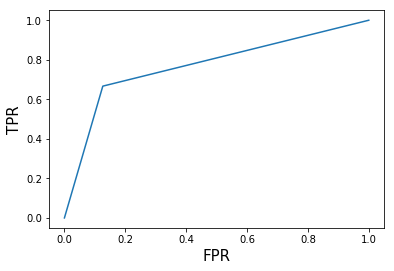

In [331]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_NB, predicted,pos_label=1)
metrics.auc(fpr,tpr)
#x = np.array(fpr)
#y = np.array(tpr)
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.plot(fpr,tpr)

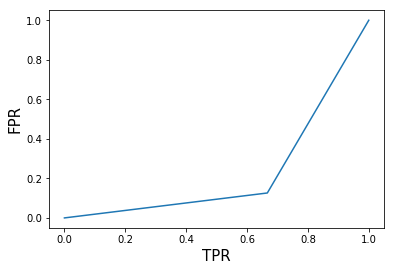

In [332]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_NB, predicted,pos_label=1)
metrics.auc(fpr,tpr)
plt.ylabel('FPR',fontsize=15)
plt.xlabel('TPR',fontsize=15)
plt.plot(tpr,fpr)

In [333]:
print("Precision Score: ", (precision_score(y_test_NB,predicted,average='weighted' )))

Precision Score:  0.782350851884


# Traning Models - Decision Tree


Traning Average accuracy: 0.866201548098
Traning Average Precision: 0.851697543208
Accuracy on test set:  0.854260089686


{'age': 0.42393511969346609,
 'bot_in_des': 0.017659734395846546,
 'bot_is_substr': 0.0,
 'default_profile_image': 0.0,
 'favourites_count': 0.087223124015799597,
 'followers_count': 0.085059431255221113,
 'friends_count': 0.177319267617563,
 'listedcount': 0.060452538392027196,
 'screen_name_len': 0.018098197087470666,
 'statuses_count': 0.13025258754260577,
 'verified': 0.0}

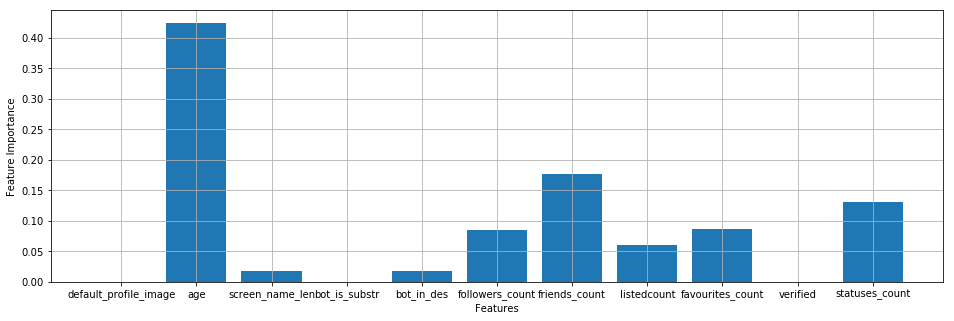

In [334]:
dt = DecisionTreeClassifier(criterion='entropy')

# treeNames are only the numerical and binary features with importance > 0 
treeNames=['default_profile_image','age','screen_name_len', 'bot_is_substr','bot_in_des','followers_count','friends_count','listedcount', 'favourites_count','verified','statuses_count']

# Getting the training sets and fitting the tree
df_train = train_df[treeNames+['bot']]
x_train = train_df[treeNames]
y_train = train_df.bot.astype(bool)
dt.fit(x_train, y_train)

# Evaluating the tree with cross-val
accuracy = cross_val_score(dt, x_train, y_train, cv=5, scoring = "accuracy")
precision = cross_val_score(dt, x_train, y_train, cv=5, scoring = "precision")

# Graphing the feature importance 
import matplotlib.pyplot as plt
%matplotlib inline

feature_mi_dict = dict(zip(df_train.columns.values,dt.feature_importances_))
feature_mi_dict
feature_importance_X = feature_mi_dict.keys()
feature_importance_Y = feature_mi_dict.values()
plt.rcParams['figure.figsize'] = (16, 5)
plt.bar(range(len(feature_mi_dict)), feature_mi_dict.values(), align='center')
plt.xticks(range(len(feature_mi_dict)), feature_mi_dict.keys())
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.grid(True)

# Printing the evaluations 
print("Traning Average accuracy:",accuracy.mean())
print("Traning Average Precision:",precision.mean())


predicts = dt.predict(X_test[treeNames])

Test_accuracy = metrics.accuracy_score(test_df['bot'], predicts)

print('Accuracy on test set: ',Test_accuracy )





feature_mi = dt.feature_importances_

feature_mi

feature_mi_dict = dict(zip(x_train.columns.values,feature_mi))

feature_mi_dict

In [335]:
def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
   
    fpr, tpr, thresholds = roc_curve(truth,preds, pos_label=1)
    roc_auc = auc(fpr,tpr)

    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds,pos_label=1 )
        roc_auc = auc(fpr, tpr)

    c = (np.random.rand(), np.random.rand(), np.random.rand())

    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

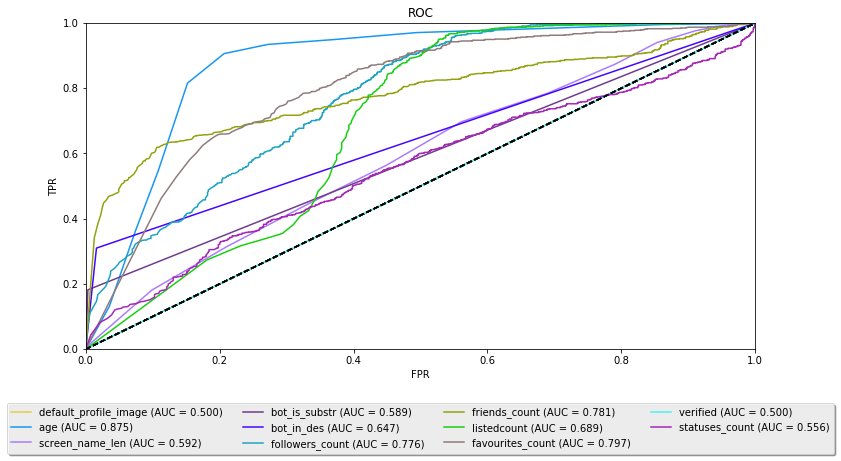

In [340]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

train_df_modf = train_df[treeNames]


feature_auc_dict = {}
for col in train_df_modf.columns:
    feature_auc_dict[col] = plotUnivariateROC(train_df_modf[col], Y_train, col)


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [337]:



# Splitting the set 80-20 with train_test_split from sklearn metrics
#bot = df['bot']
#X_train, X_test, Y_train, Y_test = train_test_split(df[treeNames].ix[:,0:13], bot, test_size=0.2, random_state=42)


min_samples_split_values = list(range(20,70,5))
min_samples_leaf_values = list(range(20,30,1))

test_set_accuracy = []

for i in range(10):
    
    min_samples_split_value = min_samples_split_values[i]
    for j in range(10):
        min_samples_leaf_value = min_samples_leaf_values[j]    
        
        # Fitting and evaluating a tree
        splitDt = DecisionTreeClassifier(criterion='entropy',max_depth = 5, min_samples_split = min_samples_split_value,  min_samples_leaf = min_samples_leaf_value)
        splitDt.fit(X_train[treeNames], Y_train)
        predict = splitDt.predict(X_test[treeNames])
        accuracy = metrics.accuracy_score(predict, Y_test)
    
        test_set_accuracy.append(accuracy)

        
        
print("Maximum Accuracy:", max(test_set_accuracy),"\nMinimum Accuracy:", min(test_set_accuracy))
print("Average Accuracy:",sum(test_set_accuracy)/len(test_set_accuracy))





Maximum Accuracy: 0.872197309417 
Minimum Accuracy: 0.856502242152
Average Accuracy: 0.863766816143


In [303]:
#Cross Validation Scores:


precision = cross_val_score(dt, X_test[treeNames], Y_test, cv=5, scoring = 'precision')
avg_precision = sum(precision) / 5


recall = cross_val_score(dt, X_test[treeNames], Y_test, cv=5, scoring = 'recall')
avg_recall = sum(recall) / 5


F1 = cross_val_score(dt, X_test[treeNames], Y_test, cv=5, scoring = 'f1')
avg_F1 = sum(F1) / 5

AUC = cross_val_score(dt, X_test[treeNames], Y_test, cv=5, scoring = 'roc_auc')
avg_AUC = sum(AUC) / 5



print('Cross-validation:')


print('Using decision tree for precision score:', precision)
print('Take the average of decision tree precision score:', avg_precision )
print('' )

print('Using decision tree for recall score:', recall )
print('Take the average of recall score:', avg_recall )
print('' )



print('Using decision tree for F1 score:', F1 )
print('Take the average of decision tree F1 score:', avg_F1 )
print('' )



print('Using decision tree for AUC score:', AUC )
print('Take the average of decision tree AUC score:', avg_AUC )
print('' )
print('' )



Cross-validation:
Using decision tree for precision score: [ 0.825       0.84210526  0.85365854  0.84615385  0.87179487]
Take the average of decision tree precision score: 0.847742503538

Using decision tree for recall score: [ 0.87804878  0.7804878   0.85365854  0.85        0.85      ]
Take the average of recall score: 0.84243902439

Using decision tree for F1 score: [ 0.85365854  0.825       0.83333333  0.84615385  0.86075949]
Take the average of decision tree F1 score: 0.843781041949

Using decision tree for AUC score: [ 0.83300149  0.82901941  0.86560478  0.87291667  0.86041667]
Take the average of decision tree AUC score: 0.852191803551




# Traning Models - Logistic Regression